# Bbot system and control analisys with Python
---

This Colab file was created for the tutorial about the control systems of Bbot, a self-balancing robot. This Colap contains the mathematical model, the control system project and simulation, as well as the simulation data plots and a gif generator with the performance of the system in the simulation.

A better explanation of the code snippets here can be found in [rasc](https://mhar-vell.github.io/rasc/2021-09-23-py-control-bbot/).

In [2]:
# !pip install control
# !pip install sympy

## Symbols Definitions
---

Here we define all the `sympy.symbols` used in the mathematical model of Bbot.

In [3]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

#--- Model Parameters ---
d       = symbols('d',    real=True, positive=True)         # Distance between wheels
visc    = symbols('c_alpha',real=True)                      # Viscous, damping constant 
l       = symbols('l',    real=True, positive=True)         # Height of the COM
r       = symbols('r',    real=True, positive=True)         # Radius of the wheel
Mp      = symbols('M_p',  real=True, positive=True)         # Mass of the pendulum without the wheels
Mw      = symbols('M_w',  real=True, positive=True)         # Mass of each wheel
Iw_c    = symbols('I_wc',  real=True)                       # MOI wheel center
Iw_r    = symbols('I_wr',  real=True)                       # MOI wheel radial
Ip_x    = symbols('I_px',  real=True)                       # MOI pendulum x
Ip_y    = symbols('I_py',  real=True)                       # MOI pendulum y
Ip_z    = symbols('I_pz',  real=True)                       # MOI pendulum z

#--- Constants & Aux. variables ---
g = symbols('g', constant=True)                             # Gravity acceleration
t = symbols('t', real=True)                                 # Time

#--- State Variables ---
x           = symbols('x',  real=True)                      # Linear pos
pitch       = symbols('theta',  real=True)                  # Pitch angle
yaw         = symbols('psi',  real=True)                    # Yaw angle
x_vel       = Derivative(x,t)                               # Linear vel
pitch_vel   = Derivative(pitch,t)                           # Pitch vel
yaw_vel     = Derivative(yaw,t)                             # Yaw vel
x_acc       = Derivative(x_vel,t)                           # Linear acc
pitch_acc   = Derivative(pitch_vel,t)                       # Pitch acc
yaw_acc     = Derivative(yaw_vel,t)                         # Yaw acc

#--- Inputs ---
Tl = symbols('T_L', real=True)                              # Torque of the left wheel
Tr = symbols('T_R', real=True)                              # Torque of the right wheel

## Defining all the matrices of the system
----------

Here we create `sympy.Matrix` objects based on the matrices of the system of ODE present in the articles referenced in [rasc](https://mhar-vell.github.io/rasc/2021-09-23-py-control-bbot/).

In [4]:

#*--- Matrices for the 3 states model
M = Matrix([[Mp+2*Mw+2*Iw_c/r**2, Mp*l*cos(pitch) ,                                                                     0],
            [ Mp*l*cos(pitch)   , Ip_y+Mp*l**2    ,                                                                     0],
            [0                  ,                0, Ip_z+2*Iw_r+(Mw+Iw_c/r**2)*d**2/2-(Ip_z-Ip_x-Mp*l**2)*sin(pitch)**2  ]])

C = Matrix([[                      0, -Mp*l*pitch_vel*sin(pitch),                          -Mp*l*yaw_vel*sin(pitch)],
            [                      0,                          0, (Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch)],
            [Mp*l*yaw_vel*sin(pitch), -(Ip_z-Ip_x-Mp*l**2)*yaw_vel*sin(pitch)*cos(pitch), -(Ip_z-Ip_x-Mp*l**2)*pitch_vel*sin(pitch)*cos(pitch)]])

D = Matrix([[2*visc/r**2, -2*visc/r, 0],
            [-2*visc/r, 2*visc, 0],
            [0, 0, (d**2/(2*r**2))*visc]])

B = Matrix([[     1/r,     1/r],
            [      -1,      -1],
            [-d/(2*r), d/(2*r)]])

G = Matrix([[0],[-Mp*l*g*sin(pitch)], [0]])

q = Matrix([[x],[pitch],[yaw]])

q_diff = Matrix([[x_vel],[pitch_vel],[yaw_vel]])

q_2diff = Matrix([[x_acc],[pitch_acc],[yaw_acc]])

u = Matrix([[Tl],[Tr]])

M_inv = M.inv()

## Show system in expression form
---

Here we combine the all the matrices to form a column vector with all the ODEs of the system.

In [5]:
expr_model = M_inv*((B*u-G)-(C+D)*q_diff)
eqts_model = Eq(q_2diff,expr_model)
eqts_model

Eq(Matrix([
[    Derivative(x, (t, 2))],
[Derivative(theta, (t, 2))],
[  Derivative(psi, (t, 2))]]), Matrix([
[     M_p*l*r**2*(M_p*g*l*sin(theta) - T_L - T_R - 2*c_alpha*Derivative(theta, t) + 2*c_alpha*Derivative(x, t)/r - (-I_px + I_pz - M_p*l**2)*sin(theta)*cos(theta)*Derivative(psi, t)**2)*cos(theta)/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(theta)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2) + (-I_py*r**2 - M_p*l**2*r**2)*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(theta)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2)],
[M_p*l*r**2*(M_p*l*sin(theta)*Derivative(psi, t)**2 + T_L/r + T_R/r - 2*c_alpha*Derivative(x, t)/r**2 - (-M_p*l*sin(theta)*Derivative(theta, t) - 2*c_alpha/r)*Derivative(theta, t))*cos(theta)/(-2*I_py*I_wc - I

In [6]:

#* Convert real variables into state-space variables

# Build state vector
real_state_vec = q_diff.row_insert(4,q)
state_vec = Matrix(list(symbols('x1:7',real=True)))
state_eq = Eq(state_vec,real_state_vec)
state_eq

Eq(Matrix([
[x1],
[x2],
[x3],
[x4],
[x5],
[x6]]), Matrix([
[    Derivative(x, t)],
[Derivative(theta, t)],
[  Derivative(psi, t)],
[                   x],
[               theta],
[                 psi]]))

In [7]:
#* Build the vector of system equations

system_equations = expr_model.row_insert(4,q_diff)

#* Substitute the real variables with the state-stape model variables: x1:x6

for i in range(6):
  system_equations = system_equations.subs(real_state_vec[i],state_vec[i])

#* Show the system of equations that will be used in the state space form 

eq_sys = system_equations
eq_sys

Matrix([
[     M_p*l*r**2*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))*cos(x5)/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2) + (-I_py*r**2 - M_p*l**2*r**2)*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2)],
[M_p*l*r**2*(M_p*l*x3**2*sin(x5) + T_L/r + T_R/r - 2*c_alpha*x1/r**2 - x2*(-M_p*l*x2*sin(x5) - 2*c_alpha/r))*cos(x5)/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2) + (-2*I_wc - M_p*r**2 - 2*M_w*r**2)*(M_p*g*l*sin(x5) - T_L - T_R - 2*c_alpha*x2 + 2*c_alpha*x1/r - x3**2*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5))/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r*

In [8]:

#* Calcualte the jacobian for the A and B matrix of the continuos time system
Ac = system_equations.jacobian(state_vec)
Bc = system_equations.jacobian(u)

Ac
# Bc

Matrix([
[ 2*M_p*c_alpha*l*r*cos(x5)/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2) - 2*c_alpha*(-I_py*r**2 - M_p*l**2*r**2)/(r**2*(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2)),     -2*M_p*c_alpha*l*r**2*cos(x5)/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2) + (-I_py*r**2 - M_p*l**2*r**2)*(2*M_p*l*x2*sin(x5) + 2*c_alpha/r)/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2),          -2*M_p*l*r**2*x3*(-I_px + I_pz - M_p*l**2)*sin(x5)*cos(x5)**2/(-2*I_py*I_wc - I_py*M_p*r**2 - 2*I_py*M_w*r**2 - 2*I_wc*M_p*l**2 + M_p**2*l**2*r**2*cos(x5)**2 - M_p**2*l**2*r**2 - 2*M_p*M_w*l**2*r**2) + 2*M_p*l*x3*(-I_py*r**2 - M_p*l**2*r**2)*sin(x5)/(-

## Applying Model Parameters & Fixed Point
---

Here we define the fixed point around which the system is linearized. We also apply this point, as well as the model parameters, to the jacobian matrices previously calculated.

In [9]:

#* Evaluate Ac and Bc at the fixed points

fixed_point = [0,0,0,0.17,0,0] # Values for dx/dt
input_fixed_points = [0,0]

Ac_eval = Ac.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

Bc_eval = Bc.subs([(state_vec[0], fixed_point[0]),
                   (state_vec[1], fixed_point[1]),
                   (state_vec[2], fixed_point[2]),
                   (state_vec[3], fixed_point[3]),
                   (state_vec[4], fixed_point[4]),
                   (state_vec[5], fixed_point[5]),
                   (Tl,input_fixed_points[0]),
                   (Tr,input_fixed_points[1])])

# Define the values of each Model Parameter

d_v    = (d,    0.1431)
visc_v = (visc, 0.01)
r_v    = (r,    0.05)
Mp_v   = (Mp,   1.68)
Mw_v   = (Mw,   0.200)
Iw_c_v = (Iw_c, 2.795e-4)
Iw_r_v = (Iw_r, 1.568e-4)
g_v    = (g,    9.81)

#-- Pose A ---
# l_v    = (l,   0.1806)
# Ip_x_v = (Ip_x, 0.02500992)
# Ip_y_v = (Ip_y, 0.02255237)
# Ip_z_v = (Ip_z, 0.00546422)

#-- Pose B ---
# l_v    = (l,   0.17348)
# Ip_x_v = (Ip_x, 0.02387201)
# Ip_y_v = (Ip_y, 0.02163341)
# Ip_z_v = (Ip_z, 0.00568317)

#-- Pose C ---
l_v    = (l,   0.09023379)
Ip_x_v = (Ip_x, 0.01424258)
Ip_y_v = (Ip_y, 0.01305842)
Ip_z_v = (Ip_z, 0.0062261)

#* Plug in the Model parameters values 

Ac_lin = Ac_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
Bc_lin = Bc_eval.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])

Ac_np = np.array(Ac_lin) # Converts it into a numpy array
Bc_np = np.array(Bc_lin) # Converts it into a numpy array

Matrix(Bc_np)

Matrix([
[ 17.7754685546368,  17.7754685546368],
[-138.183171594359, -138.183171594359],
[  -147.0382821871,    147.0382821871],
[                0,                 0],
[                0,                 0],
[                0,                 0]])

## Discretization of the system 
---

Here we use the `control.c2d` function to discretize the system using the *zero-order hold* method. The system was defined as a state-space system using the `control.ss` function.

In [10]:
import control.matlab as ctl

Ts = 0.0125 # Sampling period. Fs = 100 hz

sysc = ctl.ss(Ac_np,Bc_np,np.eye(6),np.zeros((6,2)))
sysd = ctl.c2d(sysc,Ts,method='zoh')
Ad = sysd.A
Bd = sysd.B

In [11]:

# Reduce the system to 4 states, only, ignoring the linear and Yaw positions

Ar = np.zeros((4,4))
Ar[0:3,0:3] = Ad[0:3,0:3]
Ar[3,0:3]   = Ad[4,0:3]
Ar[0:3,3]   = Ad[0:3,4].reshape(3,)
Ar[3,3]     = Ad[4,4]

Br = np.zeros((4,2))
Br[0:3,:]   = Bd[0:3,:]
Br[3,:]     = Bd[4,:]

Matrix(Ar)
# Matrix(Br)

Matrix([
[ 0.916290516436285, 0.00375189469501096,                 0, -0.0676620369594211],
[ 0.651498643644762,    0.97418504228394,                 0,    1.06890913718733],
[                 0,                   0, 0.948756645846121,                   0],
[0.0041507105723957,  0.0123208015471576,                 0,    1.00675997446618]])

In [12]:
C_ss_r = np.diag([1,1,1,1])
D_ss_r = np.zeros((4,2))
sys_red = ctl.ss(Ar, Br, C_ss_r, D_ss_r,dt=0.0125)
sys_red.dt

0.0125

##  Motor Model
---

In [572]:
motor_modeltf = ctl.tf([0.0006618*0.02],[1, -0.8444], 0.0125)
# motor_modeld = ctl.c2d(motor_modelc,Ts=0.01,method='zoh')
motor_modeltf
# Y, T = ctl.step(motor_modelc)
# plt.plot(T,Y)

TransferFunction(array([1.3236e-05]), array([ 1.    , -0.8444]), 0.0125)

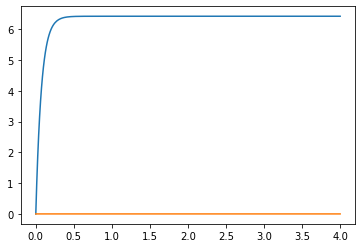

In [573]:
%matplotlib inline
motor_modelss = ctl.tf2ss(motor_modeltf)
timee = np.arange(0, 4+0.01, 0.0125)
a = [0]
y_motor = [0]
for timeee in timee[:-1]:
  a.append(motor_modelss.dynamics(t=timeee,x=[a[-1]],u=[1]))
  y_motor.append(motor_modelss.C@a[-1])

plt.plot(timee,a)
plt.plot(timee,y_motor)

In [574]:
statesss = motor_modelss.dynamics(t=timeee,x=[1.75],u=[2])
print(statesss)
print(motor_modelss.C@statesss)

[[3.4777]]
[[4.60308372e-05]]


In [575]:
motor_modelss = ctl.tf2ss(motor_modeltf)
motor_model2 = ctl.append(motor_modelss, motor_modelss)
motor_model2

StateSpace(array([[0.8444, 0.    ],
       [0.    , 0.8444]]), array([[1., 0.],
       [0., 1.]]), array([[1.3236e-05, 0.0000e+00],
       [0.0000e+00, 1.3236e-05]]), array([[0., 0.],
       [0., 0.]]), 0.0125)

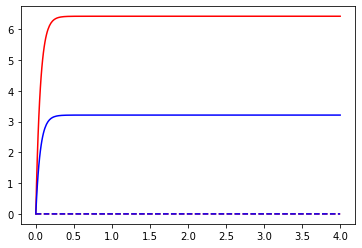

In [576]:
timee = np.arange(0, 4+0.01, 0.01)
a = np.array([[0,0]])
y_motor = np.array([[0,0]])
for timeee in timee[:-1]:
  a = np.vstack((a, motor_model2.dynamics(t=timeee,x=a[-1],u=[1,0.5]) ))
  y_motor = np.vstack((y_motor,(motor_model2.C@a[-1].reshape(2,1)).reshape(1,2)))

plt.plot(timee,a[:,0],'r')
plt.plot(timee,a[:,1],'b')
plt.plot(timee,y_motor[:,0],'r--')
plt.plot(timee,y_motor[:,1],'b--')

## Adding Motor Model to the SBR model
---


In [577]:
Afinal = np.hstack((sys_red.A, sys_red.B@motor_model2.C))
Afinal2 = np.hstack((np.zeros((motor_model2.nstates,4)), motor_model2.A))
Afinal = np.vstack((Afinal, Afinal2))

Bfinal = np.vstack((np.zeros((4, 2)), motor_model2.B))

Cfinal = np.hstack((sys_red.C, np.zeros((4,motor_model2.nstates))))
Cfinal2 = np.hstack((np.zeros((2,4)), motor_model2.C))
Cfinal = np.vstack((Cfinal, Cfinal2))
Cfinal[-2,-2] = 0
Cfinal[-1,-1] = 0

Dfinal = np.zeros((4,2))

sys_final = ctl.ss(Afinal, Bfinal, Cfinal[0:4,:], Dfinal,dt=0.01)
sys_final

StateSpace(array([[ 9.16290516e-01,  3.75189470e-03,  0.00000000e+00,
        -6.76620370e-02,  2.76994681e-06,  2.76994681e-06],
       [ 6.51498644e-01,  9.74185042e-01,  0.00000000e+00,
         1.06890914e+00, -2.15580901e-05, -2.15580901e-05],
       [ 0.00000000e+00,  0.00000000e+00,  9.48756646e-01,
         0.00000000e+00, -2.36987084e-05,  2.36987084e-05],
       [ 4.15071057e-03,  1.23208015e-02,  0.00000000e+00,
         1.00675997e+00, -1.37347013e-07, -1.37347013e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  8.44400000e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  8.44400000e-01]]), array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 1.]]), array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]]), array([[0., 0.],
       [0., 0.],
 

In [578]:
Matrix(abs(sys_final.pole()))

Matrix([
[0.833994178811508],
[0.965181336194869],
[ 1.09806001818003],
[0.948756645846121],
[           0.8444],
[           0.8444]])

In [579]:
ctrb_m = ctl.ctrb(sys_final.A,sys_final.B)
rank_ctrb = np.linalg.matrix_rank(ctrb_m) # If result is 6, the system is controlable

obs_m = ctl.obsv(sys_final.A,sys_final.C)
rank_obs = np.linalg.matrix_rank(obs_m) # If result is 6, the system is observable

print(rank_ctrb)
print(rank_obs)

6
6


## Augmented System
---

In [580]:
Upper_aug = np.hstack((sys_final.A, np.zeros((6,2))))
L_aug = np.hstack((np.array([[-1,0,0,0,0,0],
                             [0,0,-1,0,0,0]]), np.eye(2) ))
A_final_aug = np.vstack((Upper_aug, L_aug))

B_final_aug = np.vstack((sys_final.B,np.zeros((2,2))))

C_final_aug = np.eye(6,8,2)
C_final_aug[:4,:6] = sys_final.C

D_final_aug = np.zeros((6,2))

sys_final_aug = ctl.ss(A_final_aug, B_final_aug, C_final_aug, D_final_aug, dt=0.01)

sys_final_aug
# Matrix(B_aug)

StateSpace(array([[ 9.16290516e-01,  3.75189470e-03,  0.00000000e+00,
        -6.76620370e-02,  2.76994681e-06,  2.76994681e-06,
         0.00000000e+00,  0.00000000e+00],
       [ 6.51498644e-01,  9.74185042e-01,  0.00000000e+00,
         1.06890914e+00, -2.15580901e-05, -2.15580901e-05,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  9.48756646e-01,
         0.00000000e+00, -2.36987084e-05,  2.36987084e-05,
         0.00000000e+00,  0.00000000e+00],
       [ 4.15071057e-03,  1.23208015e-02,  0.00000000e+00,
         1.00675997e+00, -1.37347013e-07, -1.37347013e-07,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  8.44400000e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  8.44400000e-01,
         0.00000000e+00,  0.00000000e+00],
       [-1.00000000e+00

## Control Analysis
---

Here we make all the analysis of the system to design the LQR controller.

### Function `dlqr`
---

Create the `control.lqr` function for discrete systems.

In [581]:
def dlqr_calculate(G, H, Q, R, returnPE=False): # Ref.: https://github.com/python-control/python-control/issues/359#issuecomment-759423706
  '''
  Discrete-time Linear Quadratic Regulator calculation.
  State-feedback control  u[k] = -K*x[k]

  How to apply the function:    
      K = dlqr_calculate(G,H,Q,R)
      K, P, E = dlqr_calculate(G,H,Q,R, return_solution_eigs=True)

  Inputs:
    G, H, Q, R  -> all numpy arrays  (simple float number not allowed)
    returnPE: define as True to return Ricatti solution and final eigenvalues

  Returns:
    K: state feedback gain
    P: Ricatti equation solution
    E: eigenvalues of (G-HK)  (closed loop z-domain poles)
  '''
  from scipy.linalg import solve_discrete_are, inv, eig
  P = solve_discrete_are(G, H, Q, R)  #Solução Ricatti
  K = inv(H.T@P@H + R)@H.T@P@G    #K = (B^T P B + R)^-1 B^T P A 

  if returnPE == False:   return K

  from numpy.linalg import eigvals
  eigs = np.array([eigvals(G-H@K)]).T
  return K, P, eigs

### Analysis
---

In [582]:
#MATRICES WITH NO INTEGRAL ACTION

# Q_lqr_final = np.diag([ 1600 /(0.5**2), 
#                         5.5 /(0.1**2), 
#                         300 /(1**2), 
#                         47 /(0.14**2), 
#                         0 /(1**2), 
#                         0 /(1**2),
#                         0.00,
#                         0.00])

# R_lqr_final = np.diag([0.7e-2 /(0.5**2),
                    #    0.7e-2 /(0.5**2)])


# TELEOP OK
# Q_lqr_final = np.diag([ 1680 /(0.5**2), 
#                         6 /(0.1**2), 
#                         300 /(1**2), 
#                         50 /(0.14**2), 
#                         0 /(1**2), 
#                         0 /(1**2),
#                         0.001,
#                         0.0012])

# R_lqr_final = np.diag([0.71e-2 /(0.5**2),
#                        0.71e-2 /(0.5**2)])


#TELEOP OK 2 (error readings)
# Q_lqr_final = np.diag([ 1820 /(0.5**2), 
#                         6.7 /(0.1**2), 
#                         300 /(1**2), 
#                         57 /(0.14**2), 
#                         0 /(1**2), 
#                         0 /(1**2),
#                         0.001,
#                         0.0012])

# R_lqr_final = np.diag([0.701e-2 /(0.5**2),
#                        0.701e-2 /(0.5**2)])

In [613]:
Q_lqr_final = np.diag([ 8000 /(0.5**2), 
                        75 /(0.1**2), 
                        1000 /(1**2), 
                        450 /(0.14*2), 
                        0 /(1**2), 
                        0 /(1**2),
                        0,
                        0])

R_lqr_final = np.diag([1.3e-4 /(0.5**2),
                       1.3e-4 /(0.5**2)])
K_dlqr_final, S_dlqr_final, E_dlqr_final = dlqr_calculate(sys_final_aug.A,sys_final_aug.B,Q_lqr_final,R_lqr_final,True)

Matrix(K_dlqr_final)

Matrix([
[-12919.3411918064, -3960.89635807413, -597.282038109003, -29349.5532847772, 0.257863532914322, 0.111520895110095, -2.14099392008506e-38, 3.71571600043629e-17],
[-12919.3411918063, -3960.89635807414,  597.282038109007, -29349.5532847772, 0.111520895110095, 0.257863532914323, -8.48211735414508e-39, 1.47207980717306e-17]])

In [584]:
Matrix(abs(E_dlqr_final))

Matrix([
[0.758066501245503],
[0.758066501245503],
[0.965409073903629],
[0.965409073903629],
[  0.8427057427804],
[  0.8427057427804],
[0.999999999999999],
[              1.0]])

In [585]:
Vd = 0.0007*np.eye(sys_final.states) #TODO tune 0.0007
Vd[1,1] = 100.0
Vd[3,3] = 0.0019
Vn = 0.001*np.eye(sys_final.outputs) #TODO tune 0.022

Kf_dlqe_final = dlqr_calculate(sys_final.A.transpose(), sys_final.C.transpose(),Vd,Vn).transpose()
sys_KF = ctl.ss(sys_final.A-Kf_dlqe_final@sys_final.C, np.hstack((sys_final.B, Kf_dlqe_final)),np.eye(6), 0*np.hstack((sys_final.B, Kf_dlqe_final)),dt=0.01)
# sys_KF
Matrix(Kf_dlqe_final)

/tmp/ipykernel_4260/1631304275.py:1: DeprecationWarning: The StateSpace `states` attribute will be deprecated in a future release.  Use `nstates` instead.
  Vd = 0.0007*np.eye(sys_final.states) #TODO tune 0.0007
/tmp/ipykernel_4260/1631304275.py:4: DeprecationWarning: The LTI `outputs` attribute will be deprecated in a future release.  Use `noutputs` instead.
  Vn = 0.001*np.eye(sys_final.outputs) #TODO tune 0.022


Matrix([
[     0.49117022188691,   0.00375288430150991,   5.1418968592974e-21,  -0.0553164886344156],
[    0.341579996792336,     0.974178476465664, -3.25414920929892e-20,    0.770255999843955],
[-1.84183395612296e-21,  1.77051921372965e-21,     0.515319205442692, -1.8446996038017e-22],
[ -0.00467372852790142,    0.0123228877384467,  5.00347335366548e-23,    0.729644361591905],
[  3.49063995661211e-6, -3.64960046579066e-10,  -2.96984017336465e-5, -1.40872322476729e-8],
[  3.49063995652432e-6, -3.64960059050986e-10,   2.96984017350333e-5, -1.40872322624841e-8]])

### Linear simulation
---

In [586]:
%matplotlib qt
# timee = np.arange(0, 10+0.01, 0.01)
# a = np.array([[0,0.0,0,0.1,0,0]])
# y = np.array([[0,0.0,0,0.1]])

# a_series = np.array([[0,0.0,0,0.1,0,0]])
# y_series = np.array([[0,0.0,0,0.1]])

# kf_y = np.array([[0,0.0,0,0.1,0,0]])

# # motor_s = np.array([[0, 0]])
# # motor_o = np.array([[0, 0]])
# # red = np.array([[0,0.0,0,1.0]])

# u_sim = np.array([[0,0]])
# uKF_sim = np.array([[0,0]])
# u2_sim = np.array([[0,0]])

# for tim in timee[:-1]:
#   a = np.vstack((a ,np.array(sys_final.dynamics(t=tim,x=a[-1],u=u_sim[-1]))))
#   y = np.vstack((y, sys_final.C@a[-1]))

#   kf_y = np.vstack((kf_y, np.array(sys_KF.dynamics(t=tim,x=kf_y[-1],u=np.hstack((uKF_sim[-1].reshape(1,2), y[-1])))) ))
  
#   # a_series = np.vstack((a_series ,np.array(sys_series.dynamics(t=tim,x=a_series[-1],u=u2_sim[-1]))))
#   # y_series = np.vstack((y_series, sys_series.C@a_series[-1]))

#   # motor_s = np.vstack((motor_s, motor_model2.dynamics(t=tim,x=motor_s[-1], u=u2_sim[-1]) ))
#   # motor_o = np.vstack((motor_o, (motor_model2.C@motor_s[-1].reshape(2,1)).reshape(1,2) ))
#   # red = np.vstack((red, sys_red.dynamics(t=tim,x=red[-1], u=motor_o[-1]) ))

#   u_sim = np.vstack((u_sim,-K_dlqr_final@a[-1]))
#   uKF_sim = np.vstack((uKF_sim,-K_dlqr_final@kf_y[-1]))
  # u2_sim = np.vstack((u2_sim, -K_dlqr_series@a_series[-1] ))



# u_sim = np.ones((2,len(timee)))*0.01
# y,_,_ = ctl.lsim(sys_final, T=timee, U=u_sim)
# inputs = np.hstack((u_sim.transpose(), y))
# Y,_,_ = ctl.lsim(sys_KF,T=timee, U=inputs)
# # plt.plot(timee,a[:,0])
# # plt.plot(timee,a[:,1])
# fig1 = plt.figure()
# # plt.plot(timee,a[:,3],'o')
# plt.plot(timee,y[:,3])
# plt.plot(timee,kf_y[:,3],'--')
# # plt.plot(timee,y_series[:,2],'r')

# fig2 = plt.figure()
# # plt.plot(timee,a[:,3],'o')
# plt.plot(timee,y[:,1])
# plt.plot(timee,kf_y[:,1],'--')
# # plt.plot(timee,y_series[:,1],'r')

# fig3 = plt.figure()
# # plt.plot(timee,a[:,3],'o')
# plt.plot(timee,a[:,5])
# plt.plot(timee,kf_y[:,5],'--')
# plt.plot(timee,a_series[:,1],'--')

# fig1 = plt.figure()
# plt.plot(timee,Y)
# plt.plot(timee,u_sim[:,0])
# # plt.plot(timee,a[:,4])
# # plt.plot(timee,a[:,5])
# # sys_final.dynamics(t=0,x=[0,0.0,0,0.1,0,0],u=[0,0])
# # sys_final.dynamics(t=timeee,x=a[-1],u=[1,1])

In [587]:
# Vd = 0.001*np.eye(8) #TODO tune
# Vn = 0.001*np.eye(6) #TODO tune

# Kf_dlqe_final, Sf_dlqe_final, Ef_dlqe_final = dlqr_calculate(sys_final.A.transpose(), sys_final.C.transpose(),Vd,Vn,True)

# Matrix(Kf_dlqe_final.transpose())

## System Simulation
---

The simulation was done via te `scipy.integrate` module, using the `ode` class.

In [588]:
sys2sim = system_equations.subs([d_v,visc_v,l_v,r_v,Mp_v,Mw_v,Iw_c_v,Iw_r_v,Ip_x_v,Ip_y_v,Ip_z_v,g_v])
sys2sim.row_del(3)
sys2sim.row_del(4)

state_initial_conditions = [0,0.0,0,0.5]
initial_inputs = [0,0]
# x_yaw_refs = np.array([0.2, 1])
t0 = 0

#* Create lambda functions of the system and the jacobian

reduced_state_vec = Matrix(list(symbols('x1:4, x5',real=True)))

func = lambdify([t, reduced_state_vec, u],sys2sim,'numpy')

# func(0,state_initial_conditions, initial_inputs) # Test the lambda function

In [589]:
from scipy import integrate

simulator = integrate.ode(func)                                     # Ode class object used for simulation
simulator.set_initial_value(state_initial_conditions, t0)           # Set initial consitions of the system
simulator.set_integrator('vode')
simulator.set_f_params(initial_inputs)                              # Set the initial inputs (wheel torques) values in the system
# simulator.set_jac_params(initial_inputs)                            # Set the initial inputs (wheel torques) values in the jacobian

t1 = 25                                                           # Max. time for simulation  
dt = 0.01                                                          # Simulation time step
controller_time = 0                                                # Initial controller time (-1 means: "provide a control effort based on the initial states") 
controller_calls = 0                                                # Counts how many times the controller was called (just debug)

# estimated_states_history = np.array(state_initial_conditions, dtype=object)
# estimated_states_history = np.hstack((estimated_states_history, np.zeros(4))).reshape(8,1)

time_history = np.arange(start=0,stop=t1+1*dt,step=dt)
input_history = np.array(initial_inputs,dtype=object).reshape(2,1)

motor_states = np.array([[0],[0]])
motor_outputs = np.array([[0],[0]])
estimated_states = np.array([[0],[0], [0], [0.2], [0], [0]])
history = np.array(state_initial_conditions).reshape(4,1)

x_error = 0
yaw_error = 0
x_yaw_refs = np.array([0.2, 0])

# KF = Kf_dlqe_final.transpose()

mag_NOISE_y = 1e-3 
P = 0.0001*np.eye(6)
Vd = 0.0006*np.eye(6) #TODO tune 0.0007
Vn = 0.006*np.eye(4) #TODO tune 0.022

while simulator.successful() and simulator.t <= t1:                 
    # Simulation main loop
    motor_states = motor_model2.dynamics(t=simulator.t+dt, x=motor_states, u=input_history[:,-1]).reshape(2,1) #estimated_states[-2:,-1],
    motor_outputs = np.hstack((motor_outputs, motor_model2.C@motor_states)) 
    
    uIMPULSE = 0.0
    if simulator.t > 3 and simulator.t < 3.2: uIMPULSE = 0.2                      # Apply a torque pulse as external disturbance from time 3 - 4
    # elif simulator.t in time_history[int(3/dt):int(4/dt)]: uIMPULSE = -0.3
    else: uIMPULSE = 0.0
    # controller_time += 1
    
    simulator.set_f_params(motor_outputs[:,-1] + uIMPULSE)       # Update the controller values in the systems equations
    history_last = np.array([simulator.integrate(simulator.t+dt)],dtype=object).reshape(4,1) + np.random.rand(4,1)*mag_NOISE_y        # Simulate one time step and save in history
    
    estimated_statesp = (sys_final.A@estimated_states[:,-1]).reshape(6,1) + sys_final.B@input_history[:,-1].reshape(2,1)
    Ymodelo = sys_final.C@estimated_statesp
    P = sys_final.A@P@sys_final.A.transpose() + Vd

    KF = P@sys_final.C.transpose()@np.linalg.inv(sys_final.C@P@sys_final.C.transpose()+Vn)
    estimated_states = np.hstack((estimated_states, estimated_statesp + KF@(history_last[:,-1].reshape(4,1)-Ymodelo) ))
    P = (np.eye(6) - KF@sys_final.C)@P

    # estimated_states = np.hstack((estimated_states, (sys_KF.dynamics(t=simulator.t+dt, x=estimated_states[:,-1], u=np.vstack((input_history[:,-1].reshape(2,1), history_last)) )).reshape(6,1))) #estimated_states[:,-1]
    history = np.hstack((history, history_last))  

    if simulator.t > 3:                         # Apply a reference change for X and Yaw vel
        x_yaw_refs = np.array([0.2, 0])
    
    x_error += x_yaw_refs[0] - estimated_states[0,-1] 
    yaw_error += x_yaw_refs[1] - estimated_states[2,-1]
    error_matrix = np.array([[x_error],[yaw_error]])
    
    final_states = np.vstack((estimated_states[:,-1], error_matrix))
    
    input_history = np.hstack((input_history, (-K_dlqr_final@final_states[:,-1].reshape(8,1)).reshape(2,1)))
    
print(simulator.get_return_code())


2


In [590]:

history_a = np.asarray(history)
input_history_a = np.asarray(input_history)
estimated_states_a = np.asarray(estimated_states)
motor_outputs_a = np.asarray(motor_outputs)
x_pos = integrate.cumtrapz(y = history[0,:],x = time_history,initial=0) # Integrate the Velocity values to get position information

## Plotting & Animation
----

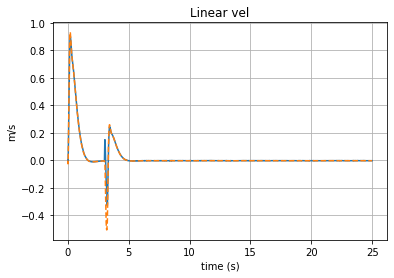

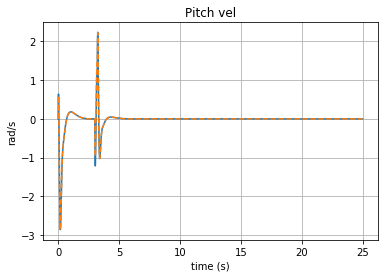

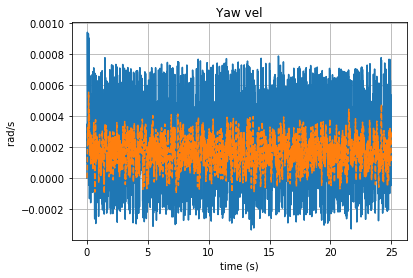

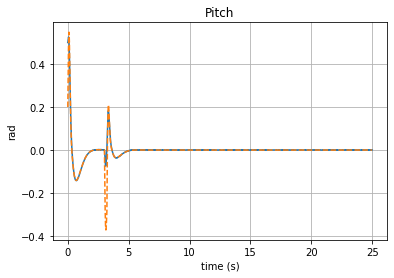

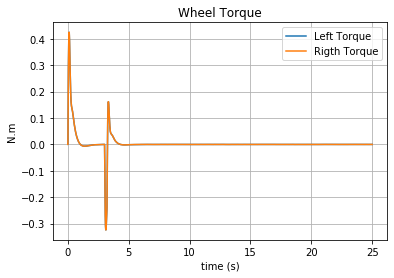

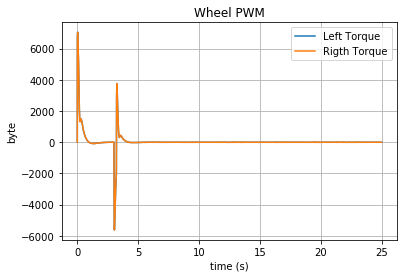

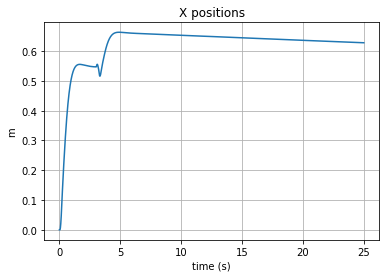

In [591]:
%matplotlib inline
fig1 = plt.figure()
plt.plot(time_history,history_a[0,:],'-')
plt.plot(time_history,estimated_states_a[0,:],"--")
plt.title("Linear vel")
plt.xlabel("time (s)")
plt.ylabel("m/s")
plt.grid()

fig2 = plt.figure()
plt.plot(time_history,history_a[1,:])
plt.plot(time_history,estimated_states_a[1,:],"--")
plt.title("Pitch vel")
plt.xlabel("time (s)")
plt.ylabel("rad/s")
plt.grid()

fig3 = plt.figure()
plt.plot(time_history,history_a[2,:])
plt.plot(time_history,estimated_states_a[2,:],"--")
plt.title("Yaw vel")
plt.xlabel("time (s)")
plt.ylabel("rad/s ")
plt.grid()

fig4 = plt.figure()
plt.plot(time_history,history_a[3,:])
plt.plot(time_history,estimated_states_a[3,:],"--")
plt.title("Pitch")
plt.xlabel("time (s)")
plt.ylabel("rad")
plt.grid()

fig5 = plt.figure()
plt.plot(time_history,motor_outputs_a[0,:], label='Left Torque')
plt.plot(time_history,motor_outputs_a[1,:], label='Rigth Torque')
plt.title("Wheel Torque")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("N.m")
plt.grid()

fig5 = plt.figure()
plt.plot(time_history,input_history_a[0,:], label='Left Torque')
plt.plot(time_history,input_history_a[1,:], label='Rigth Torque')
plt.title("Wheel PWM")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("byte")
plt.grid()

fig7 = plt.figure()
plt.plot(time_history,x_pos)
plt.title("X positions")
plt.xlabel("time (s)")
plt.ylabel("m")
plt.grid()

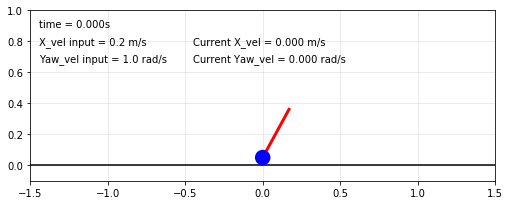

In [592]:
#Generates an animation using Matplotlib
%matplotlib inline
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation

xlim = (-1.5,1.5)
ylim = (-0.1,1.0)

fig = plt.figure(figsize=(8.3333, 7.25), dpi=72) #figsize=(8.3333, 7.25), dpi=72
ax = fig.add_subplot(111,xlim=xlim,ylim=ylim)
ax.set_aspect('equal')
ax.grid(alpha = 0.3)

height = 0.354

ax.plot([xlim[0],xlim[1]],[0,0],'-k')         # Ground

pend_rod, = ax.plot([x_pos[0], x_pos[0]+height*np.math.sin(history[3,0])],[r_v[1],r_v[1] + height*np.math.cos(history[3,0])], 'r', lw=3)
pend_wheel = ax.add_patch(Circle((x_pos[0],r_v[1]), r_v[1], fc='b', zorder=3))
time_template = 'time = %.3fs'
x_ref_template = 'X_vel input = %.1f m/s'
yaw_ref_template = 'Yaw_vel input = %.1f rad/s'

x_curr_template = 'Current X_vel = %.3f m/s'
yaw_curr_template = 'Current Yaw_vel = %.3f rad/s'


time_text = ax.text(0.02, 0.9, '', transform=ax.transAxes)
x_ref_text = ax.text(0.02, 0.8, '', transform=ax.transAxes)
yaw_ref_text = ax.text(0.02, 0.7, '', transform=ax.transAxes)
x_curr_text = ax.text(0.35, 0.8, '', transform=ax.transAxes)
yaw_curr_text = ax.text(0.35, 0.7, '', transform=ax.transAxes)

def init_anim():
  pend_rod, = ax.plot([x_pos[0], x_pos[0]+height*np.math.sin(history[3,0])],[r_v[1],r_v[1] + height*np.math.cos(history[3,0])], 'r', lw=3)
  pend_wheel = ax.add_patch(Circle((x_pos[0],r_v[1]), r_v[1], fc='b', zorder=3))
  time_text.set_text('')
  x_ref_text.set_text('')
  yaw_ref_text.set_text('')
  x_curr_text.set_text('')
  yaw_curr_text.set_text('')
  return pend_rod, pend_wheel, time_text, x_ref_text, yaw_ref_text, x_curr_text, yaw_curr_text
  
def animate(i):
  xaxis = [x_pos[i], x_pos[i] + height*np.math.sin(history[3,i])]
  yaxis = [r_v[1], r_v[1] + height*np.math.cos(history[3,i])]
  pend_rod.set_data(xaxis,yaxis)
  pend_wheel.set_center((x_pos[i],r_v[1]))
  
  time_text.set_text(time_template % (time_history[i]))
  x_curr_text.set_text(x_curr_template % (history[0,i]))
  yaw_curr_text.set_text(yaw_curr_template % (history[2,i]))
  
  if time_history[i] > 3:
    x_ref_text.set_text(x_ref_template % (-0.3))
    yaw_ref_text.set_text(yaw_ref_template % (0.0))
  else:
    x_ref_text.set_text(x_ref_template % (0.2))
    yaw_ref_text.set_text(yaw_ref_template % (1.0))
  return pend_rod, pend_wheel, time_text, x_ref_text, yaw_ref_text

anim = FuncAnimation(fig, animate,frames=len(time_history),interval=10,blit=True)

In [593]:
# anim.save("animation.gif", fps=36) #Generates a .gif for the animation